In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from tensorflow.keras.models import load_model
model = load_model('../Baybayin OCR/OCR try/BRM3.h5')
def get_predictions(X_test):
 
    predictions = model.predict(X_test)    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

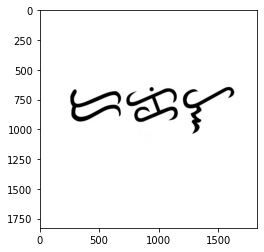

In [3]:
import cv2
image_file = '../test/DAKILA.jpg'
image_test = cv2.imread(image_file)
plt.imshow(image_test)
plt.show()

In [4]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [5]:
import imutils
def char_finder(image_file: str, out_size=32):

    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray ,120,255,cv2.THRESH_BINARY_INV)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,35))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    char = []
    j = 0
    labels = []
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            digit_crop = gray[y:y + h, x:x + w]

        size_max = max(w, h)
        print(j, w*h)
        digit_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            digit_square[y_pos:y_pos + h, 0:w] = digit_crop
        elif w < h:
            x_pos = size_max//2 - w//2
            digit_square[0:h, x_pos:x_pos + w] = digit_crop
        else:
            digit_square = digit_crop

        # Resize digit to 28x28 and add digit and its X-coordinate
        char.append((x,(cv2.resize(digit_square, (out_size, out_size), interpolation=cv2.INTER_AREA))))
        labels.append(str(j))
        j += 1 

    # Sort array in place by X-coordinate
    char.sort(key=lambda x: x[0], reverse=False)
    
    # Tranform digits to tensor
    char_new =[]
    for i in range(len(char)):
        char_new.append(char[i][1])
    char_res = np.reshape(char_new, (j, 32, 32, 1))
    char_res = np.where(char_res > 225, 255, char_res)
    char_res = np.where(char_res < 125, 0, char_res)

    return char_res, labels

In [6]:
X_user_test, Y_user_test = char_finder(image_file)

0 128775
1 140075
2 183180


In [7]:
def plot_images_test(X, Y):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    plt.gray()
    for i in range(len(Y)):        
        plt.subplot(1,len(Y),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(X[i]))
        plt.xlabel(Y[i])
    plt.show()

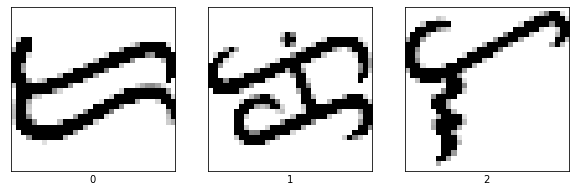

In [8]:
plot_images_test(X_user_test, Y_user_test)

In [9]:
def fe_data(df, target):
    # FE: scaling data ant transform target to categorical
    df = df / 255.
    target = to_categorical(target)
    return df, target

In [10]:
X_user_test, Y_user_test = fe_data(X_user_test, Y_user_test)

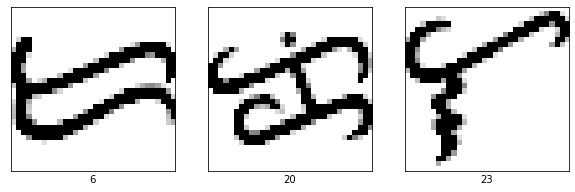

In [11]:
predictions_user = get_predictions(X_user_test)
plot_images_test(X_user_test, predictions_user)

In [12]:
pred_word1 = predictions_user.tolist()

bay_chars = ({ 0:'a',1:'b', 2:'ba',3:'bi',4:'bo',5:'d',6:'da',7:'di',8:'do',9:'e',10:'g',
            11:'ga',12:'gi',13:'gu',14:'h',15:'ha',16:'hi',17:'ho',18:'k',19:'ka',20:'ki',
            21:'ko',22:'l',23:'la',24:'li',25:'lu',26:'m',27:'ma',28:'mi',29:'mu',30:'n',
            31:'na',32:'ni',33:'ng',34:'nga',35:'ngi',36:'ngu',37:'no',38:'o',39:'p',40:'pa',
            41:'pi',42:'pu',43:'s',44:'sa',45:'si',46:'su',47:'t',48:'ta',49:'ti',50:'tu',
            51:'w',52:'wa',53:'wi',54:'wo',55:'y',56:'ya',57:'ye',58:'yo'})

pred_word = [bay_chars[int(item)] for item in pred_word1]
pred_word = ("".join(str(x) for x in pred_word))

In [13]:
pred_word

'dakila'

In [14]:
import jellyfish
with open("../Baybayin OCR/Translation/fil_corpus1.txt") as v:
    text = v.read()
    # To separate the 10,000 word list into separate strings
    # Note: can replace this txt with better list for better results
    words = text.splitlines()

In [15]:
def word_corrector(word,words_list):
    # creating a dictionnary where keys are words from words_list and values are levenshtein distance between key and word
    dict_distances = {i:jellyfish.levenshtein_distance(word,i) for i in words_list}
    # we return then the key with the lower value corresponding the the closest to word in terms of levenstein distance
    return min(dict_distances, key=dict_distances.get)

In [16]:
lev1 = word_corrector(pred_word,words)

In [17]:
def word_corrector_v3(word, words_list,threshold):
    # creating a dictionnary where keys are words from words_list and values are levenshtein distance between key and word
    dict_distances = {i:jellyfish.levenshtein_distance(word,i) for i in words_list if jellyfish.levenshtein_distance(word,i)<threshold}
    return sorted(dict_distances,key = dict_distances.get)

In [18]:
lev2 = word_corrector_v3(pred_word,words, 2)

In [19]:
if pred_word in words:
    print ("Translation: ", pred_word.title())
else:
    print ("Translation: ", lev1.title())
    if lev1 in lev2:
        lev2.remove(lev1)
    if len(lev2) > 0:
        print("Other possible translations: ")
    for i in lev2:
        if len(i) == len(pred_word):
            print(i)

Translation:  Dakila
